In [1]:
import pandas as pd
import numpy as np
import sklearn 
import warnings
warnings.filterwarnings('ignore')

Jupyter notebook inspirowany: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

# List of Techniques
- Imputation
- Handling Outliers
- Binning
- Log Transform
- One-Hot Encoding
- Grouping Operations
- Feature Split
- Scaling
- Extracting Date

In [3]:
np.random.seed(123)
fake_data=pd.DataFrame({'num':np.random.choice([None, 3,4], 100), 
                        'cat': np.random.choice([None, 'Puma','Nike','Adidas'], 100, p=[0.92, 0.03, 0.03, 0.02])})

# Braki danych

## Może usuwanie kolumn, rekordów?

In [5]:
na_ratio_columns=fake_data.isnull().mean() 
na_ratio_columns

cat    0.93
num    0.30
dtype: float64

In [7]:
data_dropped_columns=fake_data[fake_data.columns[na_ratio_columns < 0.9]]  #usuwamy kolumny gdzie braków więcej niż 90%
data_dropped_columns.shape

(100, 1)

In [11]:
data_drop_records=fake_data.loc[fake_data.isnull().mean(axis=1) < 0.9]

In [12]:
data_drop_records.shape

(73, 2)

# Imputation

## NA in numerical variable

In [13]:
fake_data.num.value_counts()  #uwaga nie pokazuje braków!

4    38
3    32
Name: num, dtype: int64

In [14]:
pd.DataFrame(fake_data.num).info() #tutaj widać ile braków

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
num    70 non-null object
dtypes: object(1)
memory usage: 872.0+ bytes


In [15]:
num_with_0=fake_data.num.fillna(0) #kiedy ma to sens?
num_with_0.value_counts()

4    38
3    32
0    30
Name: num, dtype: int64

In [10]:
fake_data.num.fillna(fake_data.num.median(), inplace=True) #fake_data.num.mean()
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
num    100 non-null float64
cat    7 non-null object
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


### - kiedy uzupełniamy średnią a kiedy medianą?

## NA in categorical variable

In [11]:
# uzupełnianie w miejscu (wartością najbardziej popularną) - rzadko stosowane podejście
fake_data['cat'].fillna(fake_data['cat'].value_counts().idxmax(), inplace=True)
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
num    100 non-null float64
cat    100 non-null object
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [12]:
# lepsze podejście
fake_data['cat'].fillna('Other', inplace=True)
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
num    100 non-null float64
cat    100 non-null object
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


## Czy zaprezentowane sposoby uzupełniania Nan są dobre?

- Wnoszą nową informację (niekoniecznie zgodną z prawdą)

Pomysł - zróbmy dodatkową kolumnę gdzie 1 gdy w danym rekordzie był Nan, 0 gdy go nie było

In [13]:
fake_data["num"+"_missing"]=fake_data.num.isnull()*1 #najpierw tworzymy nową kolumnę a potem imputation

# Outliers

### najłatwiej wizualnie dokonać detekcji outliers poprzez boxplot

In [33]:
#dane jedynie z przedziału (średnia +- 3 sigma) - ma to sens gdy rozkład normalny
data=pd.DataFrame({'num':np.random.normal(2,0.4,1000)})
factor = 3
upper_lim = data['num'].mean () + data['num'].std () * factor
lower_lim = data['num'].mean () - data['num'].std () * factor

data = data[(data['num'] < upper_lim) & (data['num'] > lower_lim)]
data.shape

(998, 1)

In [34]:
#usuwanie na podstawie skrajnych percentyli
fake_data_numeric=pd.DataFrame({'num':np.random.exponential(size=100)})
print(fake_data_numeric)
upper_lim = fake_data_numeric['num'].quantile(.95)
lower_lim = fake_data_numeric['num'].quantile(.05)

data_percentile = fake_data_numeric[(fake_data_numeric['num'] < upper_lim) & (fake_data_numeric['num'] > lower_lim)]
data_percentile.shape

         num
0   0.788431
1   0.676894
2   0.355849
3   0.755134
4   0.669442
..       ...
95  0.233654
96  0.040068
97  1.265730
98  0.526540
99  1.989023

[100 rows x 1 columns]


(90, 1)

In [35]:
# przycinanie wartości skrajnych
fake_data_numeric.loc[(fake_data_numeric['num']> upper_lim),'num'] = upper_lim
fake_data_numeric.loc[(fake_data_numeric['num'] < lower_lim),'num'] = lower_lim

In [36]:
fake_data_numeric['num'].value_counts()

2.769721    5
0.125993    5
1.312626    1
1.471940    1
1.222900    1
           ..
0.792186    1
0.182644    1
0.616827    1
1.289227    1
2.764416    1
Name: num, Length: 92, dtype: int64

# Binning

In [37]:
data=np.random.choice(np.linspace(0,100), 100)

In [38]:
data = pd.cut(data, bins=[0,30,70,100], labels=["Young", "Mid", "Old"])

In [39]:
data

[Young, Old, Mid, Old, Young, ..., Mid, Mid, Young, Old, Mid]
Length: 100
Categories (3, object): [Young < Mid < Old]

In [40]:
geo=np.random.choice(("Poland",'Chile', 'France', 'Spain'), 100)

In [45]:
geo=pd.Series(geo)
geo

0     France
1      Spain
2      Spain
3      Spain
4     France
       ...  
95    Poland
96    Poland
97     Spain
98     Spain
99     Chile
Length: 100, dtype: object

In [43]:
#metoda z użyciem dict/defaultdict
dict_geo={'Poland': "Europe", "Chile":"South America", "France":"Europe"}
from collections import defaultdict
countries_list = [('Poland','Europe'), ('France','Europe'), ('Chile','South America')]

countries_dict = defaultdict(lambda:'Other')
for continent, country in countries_list:
     countries_dict[continent]=country

In [44]:
geo.map(countries_dict)

0            Europe
1             Other
2             Other
3             Other
4            Europe
          ...      
95           Europe
96           Europe
97            Other
98            Other
99    South America
Length: 100, dtype: object

In [46]:
geo.map(dict_geo)
#map jest szybsze niż replace

0            Europe
1               NaN
2               NaN
3               NaN
4            Europe
          ...      
95           Europe
96           Europe
97              NaN
98              NaN
99    South America
Length: 100, dtype: object

# Log transform

In [67]:
data_tail=pd.read_csv('./tail.csv')
data=data_tail.copy()

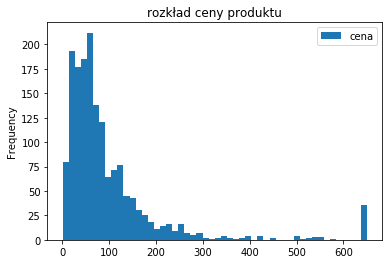

In [68]:
data.plot(bins=50, kind='hist', title='rozkład ceny produktu')

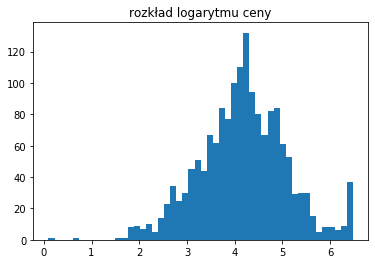

In [69]:
import matplotlib.pyplot as plt
price_after_log=np.log1p(data.values)
plt.hist(price_after_log, bins=50)
plt.title('rozkład logarytmu ceny')
plt.show()
# niektóre funkcje wymagają numpy array inne pd.DataFrame

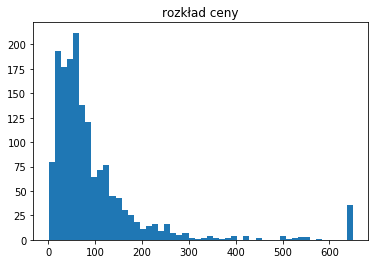

In [70]:
inv_transform=np.expm1(price_after_log)
plt.hist(inv_transform, bins=50)
plt.title('rozkład ceny')
plt.show()

# Categorical variables encoding

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = np.array(data)

# integer encode
le = LabelEncoder()
integer_encoded = le.fit_transform(values)
print(integer_encoded)
#invert
print(le.inverse_transform(integer_encoded))

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

# invert 
inverted = le.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

[0 0 2 0 1 1 2 0 2 1]
['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
['cold']


In [72]:
#inny sposób
df=pd.DataFrame({'weather':data})
df['weather'].factorize()

(array([0, 0, 1, 0, 2, 2, 1, 0, 1, 2], dtype=int64),
 Index(['cold', 'warm', 'hot'], dtype='object'))

## Target encoding
https://medium.com/@venkatasai.katuru/target-encoding-done-the-right-way-b6391e66c19f

In [73]:
! pip install category_encoders

In [74]:
import category_encoders
y=np.random.choice([0,1], 10)
te=category_encoders.target_encoder.TargetEncoder(data)
encoded=te.fit_transform(data,y ) #nie fit a fit_transform
encoded

,0
0,0.742886
1,0.742886
2,0.658720
3,0.742886
4,0.365121
5,0.365121
6,0.658720
7,0.742886
8,0.658720
9,0.365121


In [57]:
te.transform(['cold'])

,0
0,0.009485


# Scaling
- normalization
- standarization

In [58]:
from sklearn import preprocessing
data = data_tail.copy()
normalized = preprocessing.normalize(data)

In [59]:
from sklearn import preprocessing
names = data.columns
scaler = preprocessing.StandardScaler()

scaled_df = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_df, columns=names)

# Extracting info from date

In [78]:
from datetime import date

data = pd.DataFrame({'date':
['01-01-2017',
'04-12-2008',
'23-06-1988',
'25-08-1999',
'20-02-1993',
]})

#Transform string to date
data['date'] = pd.to_datetime(data.date, format="%d-%m-%Y")

#Extracting Year
data['year'] = data['date'].dt.year

#Extracting Month
data['month'] = data['date'].dt.month

#Extracting passed years since the date
data['passed_years'] = date.today().year - data['date'].dt.year

#Extracting passed months since the date
data['passed_months'] = (date.today().year - data['date'].dt.year) * 12 + date.today().month - data['date'].dt.month

#Extracting the weekday name of the date
data['day_name'] = data['date'].dt.day_name()

In [79]:
data

,date,year,month,passed_years,passed_months,day_name
0,2017-01-01,2017,1,3,38,Sunday
1,2008-12-04,2008,12,12,135,Thursday
2,1988-06-23,1988,6,32,381,Thursday
3,1999-08-25,1999,8,21,247,Wednesday
4,1993-02-20,1993,2,27,325,Saturday


### z numeru PESEL można wywnioskować o wieku osoby

# Przydatne info - automatyzacja

In [80]:
#choosing categorical data
obj_df = data.select_dtypes(include=['object'])
obj_df

,day_name
0,Sunday
1,Thursday
2,Thursday
3,Wednesday
4,Saturday


In [81]:
## convert dtypes into categorical type 
# obj_df["day_name"] = obj_df["day_name"].astype('category')

In [82]:
categorical_cols=obj_df.select_dtypes(include=['object']).columns
print(categorical_cols)

obj_df[categorical_cols] = obj_df[categorical_cols].apply(lambda col: le.fit_transform(col))
obj_df[categorical_cols].head()

Index(['day_name'], dtype='object')


,day_name
0,1
1,2
2,2
3,3
4,0


# warto poczytać
pakiet category_encoders:
- https://kiwidamien.github.io/encoding-categorical-variables.html
- https://pbpython.com/categorical-encoding.html